# Import libraries

In [1]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install snownlp

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install text_preprocessing

^C
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [98]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from snownlp import SnowNLP
import json
import time
import pandas as pd
import numpy as np
import collections
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, remove_email, remove_url, remove_punctuation
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from textblob import TextBlob
from wordcloud import WordCloud
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Collect Data

In [ ]:
# Organize the format of input into json
def save_to_files(results, json_file):
    with open(json_file, 'a', encoding='utf-8') as json_file:
        for result in results:
            json.dump(result, json_file, ensure_ascii=False)
            json_file.write('\n')

In [ ]:
#Open Facebook mbasic
url = 'https://mbasic.facebook.com'
driver = webdriver.Chrome()
driver.get(url)

In [ ]:
# Automated process : accept cookies
cookies_button = driver.find_element(By.NAME, "accept_only_essential")
cookies_button.click()

In [ ]:
# Automated process : find the input frame of 'account' and 'password'
email_input = driver.find_element(By.NAME, "email")
password_input = driver.find_element(By.NAME, "pass")

In [ ]:
# Automated process : input 'account' and 'password' of my personal account
email_input.send_keys("account")
password_input.send_keys("password")

In [ ]:
# Automated process : input 'account' and 'password' of my personal account
email_input.send_keys("account")
password_input.send_keys("password")

In [ ]:
# Automated process : log in
login_button = driver.find_element(By.NAME, "login")
login_button.click()

In [ ]:
# Automated process : confirm that I know that I am logged in to a new device
continue_button = driver.find_element(By.NAME, "submit[Continue]")
continue_button.click()

In [ ]:
# Automated process : search group 'MARKS & SPENCER UK - FANS / HAVE YOUR SAY GROUP'
search_box = driver.find_element(By.NAME, "query")
search_box.send_keys("MARKS & SPENCER UK - FANS / HAVE YOUR SAY GROUP")
search_box.submit()

In [ ]:
# Automated process : collect data from the group and save them into the JSON file.
# The loop times is set to 1000, but, if there is not too much data, the code will end directly and show an error.
# (to solve this problem, just need to decrease the loop times, but I want to collect all data of the MS group, so I didn't change the loop times)
# The JSON file is collected successfully even if the loop times is bigger than expectation.

for page in range(1000):
        results = []
        articles = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.TAG_NAME, 'article')))
        # Collected username, text, time, reacted number and comment number
        for article in articles:
            header = article.find_element(By.TAG_NAME, "header").text
            div_c = article.find_element(By.XPATH, './/header/following-sibling::div[starts-with(@class, "d")]')
            p_elements = div_c.find_elements(By.TAG_NAME, 'p')
            content_list = [p_element.text for p_element in p_elements]
            try:
                day_c = article.find_element(By.XPATH, './/footer/div')
                d_elements = day_c.find_elements(By.TAG_NAME, 'abbr')
                time_list = [d_element.text for d_element in d_elements]
                comment_c = article.find_element(By.XPATH, './/footer/div[2]')
                c_elements = comment_c.find_elements(By.TAG_NAME, 'a')
                comment_list = [c_element.text for c_element in c_elements]
            except NoSuchElementException:
                time_list = 'No'
                comment_list='No'
                continue

            result = {"header": header, "content": content_list, "timestamp": time_list, "comment": comment_list}
            results.append(result)

        # Save to JSON file
        json_output_file = 'MS_news.json'
        save_to_files(results, json_output_file)

        # Since there are not many results in one page, this is the automated process of going to next page
        more_results_link = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="m_group_stories_container"]/div/a')))
        more_results_link.click()
        WebDriverWait(driver, 10).until(EC.staleness_of(articles[-1]))

# Clean Dataset

In [86]:
# Read the json file
ms_df = pd.read_json('ms_facebook.json')
ms_df.head(5)

header                                            content  \
0  Vera van der Vliet  [Just saw an anonymous post from someone sayin...   
1       Sandra Wilson                                                 []   
2         Jayne Lewis  [Well very disappointed in the Easter dine in....   
3         Tina Miller                                                 []   
4        John Jo Gill  [Anyone had a hot 🔥 coffee from any of M&S caf...   

   timestamp  reaction  comment  
0 2024-04-14       3.0      7.0  
1 2024-04-11      91.0     25.0  
2 2024-04-01      44.0     60.0  
3 2024-04-14       0.0      0.0  
4 2024-03-28      29.0     47.0

In [87]:
# Check the shape of dataset
ms_df.shape

(5861, 5)

In [88]:
# Check the type of the variables of dataset
ms_df.dtypes

header               object
content              object
timestamp    datetime64[ns]
reaction            float64
comment             float64
dtype: object

In [89]:
# Check null of dataset
ms_df.isnull().sum()

header        0
content      12
timestamp     0
reaction      3
comment       1
dtype: int64

In [90]:
# Handle empty values
ms_df['content'] = ms_df['content'].fillna("[]")
ms_df['reaction'] = ms_df['reaction'].fillna(0)
ms_df['comment'] = ms_df['comment'].fillna(0)

In [91]:
# Rename some columns
ms_df = ms_df.rename(columns={'reaction': 'reaction_no','comment': 'comment_no',})

In [92]:
# Sort the data
ms_df = ms_df.sort_values(by='timestamp',ascending=False)
ms_df

header  \
0                                    Vera van der Vliet   
3                                           Tina Miller   
5                                 Anonymous participant   
10                                     M&S - Fosse Park   
1                                         Sandra Wilson   
...                                                 ...   
5857                                        Karen Lewis   
5858                                        Karen Lewis   
5859               Karen Lewis updated the description.   
5832                                        Karen Lewis   
5860  Karen Lewis created the group MARKS & SPENCER ...   

                                                content  timestamp  \
0     [Just saw an anonymous post from someone sayin... 2024-04-14   
3                                                    [] 2024-04-14   
5     [Shortage of petite items.\nTried to order jea... 2024-04-14   
10                                                   [] 2024-04-13   
1                                                    [] 2024-04-11   
...                                                 ...        ...   
5857                                                 [] 2015-01-27   
5858  [I am fed up asking staff at the M&S store eve... 2014-11-19   
5859  [Please tell us the good and bad things about ... 2014-11-15   
5832                                                 [] 2014-11-15   
5860                                                 [] 2014-11-15   

      reaction_no  comment_no  
0             3.0         7.0  
3             0.0         0.0  
5             2.0         0.0  
10            1.0         0.0  
1            91.0        25.0  
...           ...         ...  
5857          3.0         3.0  
5858          2.0         1.0  
5859          0.0         0.0  
5832         10.0         2.0  
5860          2.0         3.0  

[5861 rows x 5 columns]

In [93]:
# Extract year, month, day and create new columns
ms_df['year'] = ms_df['timestamp'].dt.year
ms_df['month'] = ms_df['timestamp'].dt.month
ms_df['date'] = ms_df['timestamp'].dt.day
ms_df

header  \
0                                    Vera van der Vliet   
3                                           Tina Miller   
5                                 Anonymous participant   
10                                     M&S - Fosse Park   
1                                         Sandra Wilson   
...                                                 ...   
5857                                        Karen Lewis   
5858                                        Karen Lewis   
5859               Karen Lewis updated the description.   
5832                                        Karen Lewis   
5860  Karen Lewis created the group MARKS & SPENCER ...   

                                                content  timestamp  \
0     [Just saw an anonymous post from someone sayin... 2024-04-14   
3                                                    [] 2024-04-14   
5     [Shortage of petite items.\nTried to order jea... 2024-04-14   
10                                                   [] 2024-04-13   
1                                                    [] 2024-04-11   
...                                                 ...        ...   
5857                                                 [] 2015-01-27   
5858  [I am fed up asking staff at the M&S store eve... 2014-11-19   
5859  [Please tell us the good and bad things about ... 2014-11-15   
5832                                                 [] 2014-11-15   
5860                                                 [] 2014-11-15   

      reaction_no  comment_no  year  month  date  
0             3.0         7.0  2024      4    14  
3             0.0         0.0  2024      4    14  
5             2.0         0.0  2024      4    14  
10            1.0         0.0  2024      4    13  
1            91.0        25.0  2024      4    11  
...           ...         ...   ...    ...   ...  
5857          3.0         3.0  2015      1    27  
5858          2.0         1.0  2014     11    19  
5859          0.0         0.0  2014     11    15  
5832         10.0         2.0  2014     11    15  
5860          2.0         3.0  2014     11    15  

[5861 rows x 8 columns]

In [94]:
# Check duplicated
# Since column 'content' contains list, so I need to transfer its type
ms_df['content'] = ms_df['content'].apply(tuple)
# Then check duplicated
ms_df.duplicated().sum()

25

In [95]:
# Delete duplicated
ms_df = ms_df.drop_duplicates()

In [99]:
# Plot a histogram of the number of posts published in each year
fig = px.bar(ms_df['year'].value_counts().reset_index(),
             x='year',  
             y='count',
             labels={'index': 'Year', 'year': 'Number of Posts'},
             title='Number of Posts from 2014 to 2024')
fig.update_layout(width=800, height=500)

years_reverse = sorted(ms_df['year'].unique(), reverse=False)
fig.update_xaxes(type='category', categoryorder='array', categoryarray=years_reverse)

fig.show()

C:\Users\ACER\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\ACER\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# Analyse data

In [19]:
# Describe data
print ('The length of the dataset is %s'%len(ms_df))
print ("There are %s columns in this dataset"%(len(ms_df.columns.values)))
ms_df.columns.values

The length of the dataset is 5836
There are 8 columns in this dataset


array(['header', 'content', 'timestamp', 'reaction_no', 'comment_no',
       'year', 'month', 'date'], dtype=object)

In [20]:
# Remove special symbols of header
ms_df['header'] = ms_df['header'].astype(str)
ms_df['header'] = ms_df['header'].apply(lambda x: re.sub(r"[£$~.,%/:;?_&+*=!-]", " ", x))
ms_df.head()

header                                            content  \
0      Vera van der Vliet  (Just saw an anonymous post from someone sayin...   
3             Tina Miller                                                 ()   
5   Anonymous participant  (Shortage of petite items.\nTried to order jea...   
10       M S   Fosse Park                                                 ()   
1           Sandra Wilson                                                 ()   

    timestamp  reaction_no  comment_no  year  month  date  
0  2024-04-14          3.0         7.0  2024      4    14  
3  2024-04-14          0.0         0.0  2024      4    14  
5  2024-04-14          2.0         0.0  2024      4    14  
10 2024-04-13          1.0         0.0  2024      4    13  
1  2024-04-11         91.0        25.0  2024      4    11

In [21]:
# Keep the original value in case it is useful later
ms_df['content_1'] = ms_df['content']

In [22]:
# Remove special symbols of content
ms_df['content'] = ms_df['content'].astype(str)
ms_df['content'] = ms_df['content'].apply(lambda x: re.sub(r"[~.,%/:;?_&+*=!-]", " ", x))
ms_df['content'] = ms_df['content'].apply(lambda x: re.sub(r"[0-9]", " ", x))
ms_df.head()

header                                            content  \
0      Vera van der Vliet  ("Just saw an anonymous post from someone sayi...   
3             Tina Miller                                                 ()   
5   Anonymous participant  ('Shortage of petite items \nTried to order je...   
10       M S   Fosse Park                                                 ()   
1           Sandra Wilson                                                 ()   

    timestamp  reaction_no  comment_no  year  month  date  \
0  2024-04-14          3.0         7.0  2024      4    14   
3  2024-04-14          0.0         0.0  2024      4    14   
5  2024-04-14          2.0         0.0  2024      4    14   
10 2024-04-13          1.0         0.0  2024      4    13   
1  2024-04-11         91.0        25.0  2024      4    11   

                                            content_1  
0   (Just saw an anonymous post from someone sayin...  
3                                                  ()  
5   (Shortage of petite items.\nTried to order jea...  
10                                                 ()  
1                                                  ()

In [23]:
# Preprocess text using custom preprocess functions in the pipeline
preprocess_functions = [to_lower, remove_email, remove_url, remove_punctuation]
ms_df['header'] = ms_df['header'].apply(lambda x: preprocess_text(x, preprocess_functions))
ms_df['content'] = ms_df['content'].apply(lambda x: preprocess_text(x, preprocess_functions))
ms_df.head()

header                                            content  \
0      vera van der vliet  just saw an anonymous post from someone saying...   
3             tina miller                                                      
5   anonymous participant  shortage of petite items ntried to order jeans...   
10       m s   fosse park                                                      
1           sandra wilson                                                      

    timestamp  reaction_no  comment_no  year  month  date  \
0  2024-04-14          3.0         7.0  2024      4    14   
3  2024-04-14          0.0         0.0  2024      4    14   
5  2024-04-14          2.0         0.0  2024      4    14   
10 2024-04-13          1.0         0.0  2024      4    13   
1  2024-04-11         91.0        25.0  2024      4    11   

                                            content_1  
0   (Just saw an anonymous post from someone sayin...  
3                                                  ()  
5   (Shortage of petite items.\nTried to order jea...  
10                                                 ()  
1                                                  ()

In [24]:
# Since there are some records' with 'content' equal to '', 
# it means that the user might forward others message, or just send a picture or video
# therefore I want to save them in a new dataframe
ms_df_forward = ms_df[ms_df['content'] == '']
ms_df_forward

header content  timestamp  \
3                                           tina miller         2024-04-14   
10                                     m s   fosse park         2024-04-13   
1                                         sandra wilson         2024-04-11   
13                                          tina miller         2024-04-11   
14                                       heather bulley         2024-04-11   
...                                                 ...     ...        ...   
5780                                      russell smith         2018-11-11   
5834                                      darren wilson         2017-01-14   
5857                                        karen lewis         2015-01-27   
5832                                        karen lewis         2014-11-15   
5860  karen lewis created the group marks   spencer ...         2014-11-15   

      reaction_no  comment_no  year  month  date content_1  
3             0.0         0.0  2024      4    14        ()  
10            1.0         0.0  2024      4    13        ()  
1            91.0        25.0  2024      4    11        ()  
13            7.0         0.0  2024      4    11        ()  
14            7.0         0.0  2024      4    11        ()  
...           ...         ...   ...    ...   ...       ...  
5780          8.0         0.0  2018     11    11        ()  
5834          1.0         1.0  2017      1    14        ()  
5857          3.0         3.0  2015      1    27        ()  
5832         10.0         2.0  2014     11    15        ()  
5860          2.0         3.0  2014     11    15        ()  

[1711 rows x 9 columns]

In [25]:
# The records with 'content' not equal to '' will be saved to a new dataframe
ms_df_normal = ms_df[ms_df['content'] != '']
ms_df_normal

header  \
0                       vera van der vliet   
5                    anonymous participant   
9                    anonymous participant   
16                              lorna hill   
22                        pauline bennison   
...                                    ...   
5851                           karen lewis   
5856                           karen lewis   
5854                           karen lewis   
5858                           karen lewis   
5859  karen lewis updated the description    

                                                content  timestamp  \
0     just saw an anonymous post from someone saying... 2024-04-14   
5     shortage of petite items ntried to order jeans... 2024-04-14   
9     has anyone recently received a     discount on... 2024-04-11   
16    got a £  gift voucher for easter so got a few ... 2024-04-09   
22    which store has the biggest clothing range   o... 2024-04-09   
...                                                 ...        ...   
5851  far too many waterchestnuts and not enough chi... 2016-06-18   
5856  m   s coventry precinct no trolleys again  ter... 2016-06-17   
5854  never  ever any trolleys in cov precinct store... 2015-11-07   
5858  i am fed up asking staff at the m s store ever... 2014-11-19   
5859  please tell us the good and bad things about t... 2014-11-15   

      reaction_no  comment_no  year  month  date  \
0             3.0         7.0  2024      4    14   
5             2.0         0.0  2024      4    14   
9             6.0        12.0  2024      4    11   
16           10.0         1.0  2024      4     9   
22            1.0         1.0  2024      4     9   
...           ...         ...   ...    ...   ...   
5851          0.0         2.0  2016      6    18   
5856          1.0         1.0  2016      6    17   
5854          2.0         2.0  2015     11     7   
5858          2.0         1.0  2014     11    19   
5859          0.0         0.0  2014     11    15   

                                              content_1  
0     (Just saw an anonymous post from someone sayin...  
5     (Shortage of petite items.\nTried to order jea...  
9     (Has anyone recently received a 20% discount o...  
16    (Got a £5 gift voucher for Easter so got a few...  
22    (Which store has the biggest clothing range - ...  
...                                                 ...  
5851  (Far too many #waterchestnuts and not enough c...  
5856  (M & S Coventry Precinct no trolleys again! Te...  
5854  (Never, ever any trolleys in Cov precinct stor...  
5858  (I am fed up asking staff at the M&S store eve...  
5859  (Please tell us the good and bad things about ...  

[4125 rows x 9 columns]

In [26]:
# Tokenization
ms_df_normal['content'] = ms_df_normal['content'].astype(str)
ms_df_normal['content'] = ms_df_normal['content'].apply(word_tokenize)
ms_df_normal.head()

header                                            content  \
0      vera van der vliet  [just, saw, an, anonymous, post, from, someone...   
5   anonymous participant  [shortage, of, petite, items, ntried, to, orde...   
9   anonymous participant  [has, anyone, recently, received, a, discount,...   
16             lorna hill  [got, a, £, gift, voucher, for, easter, so, go...   
22       pauline bennison  [which, store, has, the, biggest, clothing, ra...   

    timestamp  reaction_no  comment_no  year  month  date  \
0  2024-04-14          3.0         7.0  2024      4    14   
5  2024-04-14          2.0         0.0  2024      4    14   
9  2024-04-11          6.0        12.0  2024      4    11   
16 2024-04-09         10.0         1.0  2024      4     9   
22 2024-04-09          1.0         1.0  2024      4     9   

                                            content_1  
0   (Just saw an anonymous post from someone sayin...  
5   (Shortage of petite items.\nTried to order jea...  
9   (Has anyone recently received a 20% discount o...  
16  (Got a £5 gift voucher for Easter so got a few...  
22  (Which store has the biggest clothing range - ...

In [27]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

# Write a function to return the lemmatization words
def lemmatize_text(text):
    return [lemmatizer.lemmatize(word) for word in text]

ms_df_normal['content'] = ms_df_normal['content'].apply(lemmatize_text)
ms_df_normal.head()

header                                            content  \
0      vera van der vliet  [just, saw, an, anonymous, post, from, someone...   
5   anonymous participant  [shortage, of, petite, item, ntried, to, order...   
9   anonymous participant  [ha, anyone, recently, received, a, discount, ...   
16             lorna hill  [got, a, £, gift, voucher, for, easter, so, go...   
22       pauline bennison  [which, store, ha, the, biggest, clothing, ran...   

    timestamp  reaction_no  comment_no  year  month  date  \
0  2024-04-14          3.0         7.0  2024      4    14   
5  2024-04-14          2.0         0.0  2024      4    14   
9  2024-04-11          6.0        12.0  2024      4    11   
16 2024-04-09         10.0         1.0  2024      4     9   
22 2024-04-09          1.0         1.0  2024      4     9   

                                            content_1  
0   (Just saw an anonymous post from someone sayin...  
5   (Shortage of petite items.\nTried to order jea...  
9   (Has anyone recently received a 20% discount o...  
16  (Got a £5 gift voucher for Easter so got a few...  
22  (Which store has the biggest clothing range - ...

In [28]:
# Delete stop words
stop_words = set(stopwords.words('english'))
ms_df_normal['content'] = ms_df_normal['content'].apply(lambda x: [word for word in x if word not in stop_words])
ms_df_normal.head()

header                                            content  \
0      vera van der vliet  [saw, anonymous, post, someone, saying, petite...   
5   anonymous participant  [shortage, petite, item, ntried, order, jean, ...   
9   anonymous participant  [ha, anyone, recently, received, discount, hom...   
16             lorna hill  [got, £, gift, voucher, easter, got, grocery, ...   
22       pauline bennison  [store, ha, biggest, clothing, range, owlcotes...   

    timestamp  reaction_no  comment_no  year  month  date  \
0  2024-04-14          3.0         7.0  2024      4    14   
5  2024-04-14          2.0         0.0  2024      4    14   
9  2024-04-11          6.0        12.0  2024      4    11   
16 2024-04-09         10.0         1.0  2024      4     9   
22 2024-04-09          1.0         1.0  2024      4     9   

                                            content_1  
0   (Just saw an anonymous post from someone sayin...  
5   (Shortage of petite items.\nTried to order jea...  
9   (Has anyone recently received a 20% discount o...  
16  (Got a £5 gift voucher for Easter so got a few...  
22  (Which store has the biggest clothing range - ...

In [29]:
# Add a column to count the number of words appearing in Content
ms_df_normal['content_count'] = ms_df_normal['content'].apply(lambda x: len(x))

ms_df_normal.head()

header                                            content  \
0      vera van der vliet  [saw, anonymous, post, someone, saying, petite...   
5   anonymous participant  [shortage, petite, item, ntried, order, jean, ...   
9   anonymous participant  [ha, anyone, recently, received, discount, hom...   
16             lorna hill  [got, £, gift, voucher, easter, got, grocery, ...   
22       pauline bennison  [store, ha, biggest, clothing, range, owlcotes...   

    timestamp  reaction_no  comment_no  year  month  date  \
0  2024-04-14          3.0         7.0  2024      4    14   
5  2024-04-14          2.0         0.0  2024      4    14   
9  2024-04-11          6.0        12.0  2024      4    11   
16 2024-04-09         10.0         1.0  2024      4     9   
22 2024-04-09          1.0         1.0  2024      4     9   

                                            content_1  content_count  
0   (Just saw an anonymous post from someone sayin...             22  
5   (Shortage of petite items.\nTried to order jea...             14  
9   (Has anyone recently received a 20% discount o...             12  
16  (Got a £5 gift voucher for Easter so got a few...              8  
22  (Which store has the biggest clothing range - ...              9

Tfidf Vectorizer

In [30]:
# Change the word lists in the list into strings
corpus = [' '.join(content) for content in ms_df_normal['content']]

# Create TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Convert text data to matrix format
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['aan', 'abandoned', 'abbey', ..., 'éclair', 'éclairs', 'één'],
      dtype=object)

In [31]:
# Convert text data into word frequency matrix
word_counts_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_counts_df= word_counts_df.iloc[0:9].sum()

# Save results in df
df = word_counts_df.to_frame().reset_index()
df.columns = ['key', 'value']

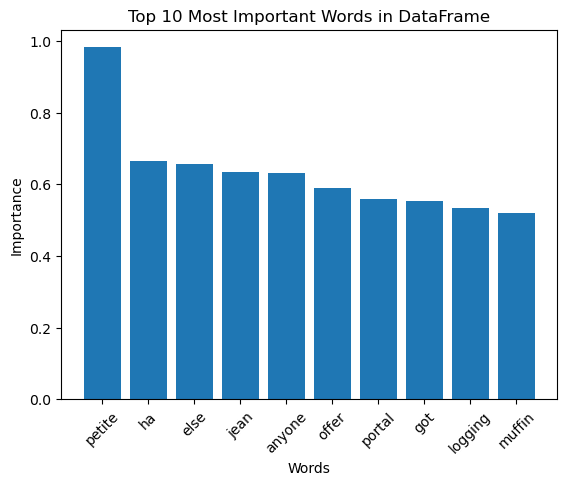

In [32]:
# Draw a histogram of the top 10 important words
top_10_words = df.nlargest(10, 'value')

words = top_10_words['key']
counts = top_10_words['value']

plt.bar(words, counts)
plt.title("Top 10 Most Important Words in DataFrame")
plt.xlabel("Words")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

Length and Similarity Analysis

In [84]:
# Plot a distribution chart for the length of content
fig = ff.create_distplot(
    [ms_df_normal['content_count']],
    ["Content Length"],
    show_hist=False,
    show_rug=False
)

fig.update_layout(
    title='Distribution of Content Lengths',
    xaxis_title="Length of Content",
    yaxis_title="Probability",
    width=800,
    height=500,
    showlegend=False
)

fig.show()

C:\Users\ACER\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\ACER\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [63]:
# Vectorize the content using TF-IDF
tfidf_headline_vectorizer = TfidfVectorizer(min_df=0)
ms_df_normal['content_article'] = [str(content) for content in ms_df_normal['content']]
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(ms_df_normal['content_article'])

ms_df_normal = ms_df_normal.reset_index(drop=True)

# Function to find similar articles based on TF-IDF
def tfidf_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(tfidf_headline_features, tfidf_headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]

    # Create a DataFrame for the similar articles
    df = pd.DataFrame({
        'publish_date': ms_df_normal['timestamp'][indices].values,
        'content': ms_df_normal['content_1'][indices].values,
        'Euclidean similarity': couple_dist[indices].ravel()
    })

    # Display queried article details
    print("="*30, "Queried Article Details", "="*30)
    print('Headline:', ms_df_normal['content_1'][indices[0]])

    # Display recommended similar articles
    print("\n", "="*25, "Recommended Articles:", "="*23)
    return df.iloc[1:,]

tfidf_based_model(100, 6)

============================== Queried Article Details ==============================
Headline: ('In love with this',)

 ========================= Recommended Articles: =======================


publish_date                content  Euclidean similarity
1   2020-10-03     (I love M and S.,)                   0.0
2   2024-02-09     (Love these! 😍♥️,)                   0.0
3   2020-08-20       (I love M&S ♥️,)                   0.0
4   2020-11-11  (I just love M&S x😍,)                   0.0
5   2021-01-07            (Love m&s,)                   0.0

Sentment Analysis

In [35]:
# Generate sentiment labels for content
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

ms_df_normal['sentiment'] = ms_df_normal['content_article'].apply(get_sentiment)

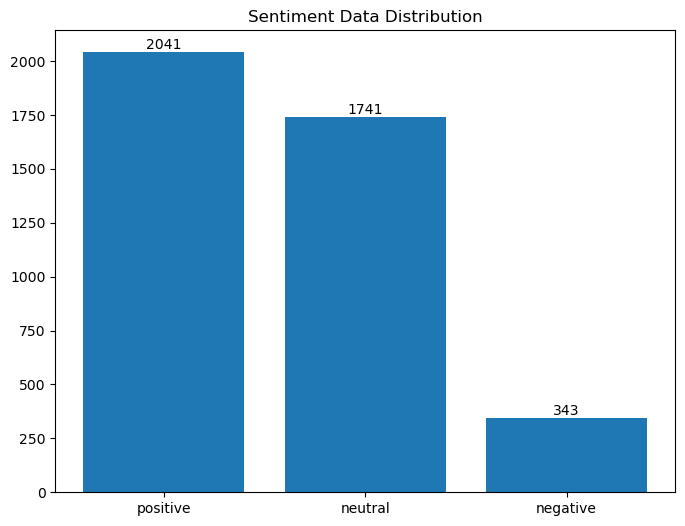

In [80]:
# Visualizing emotion labels
val_count = ms_df_normal.sentiment.value_counts()

plt.figure(figsize=(8,6))
bars = plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:523: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anacon

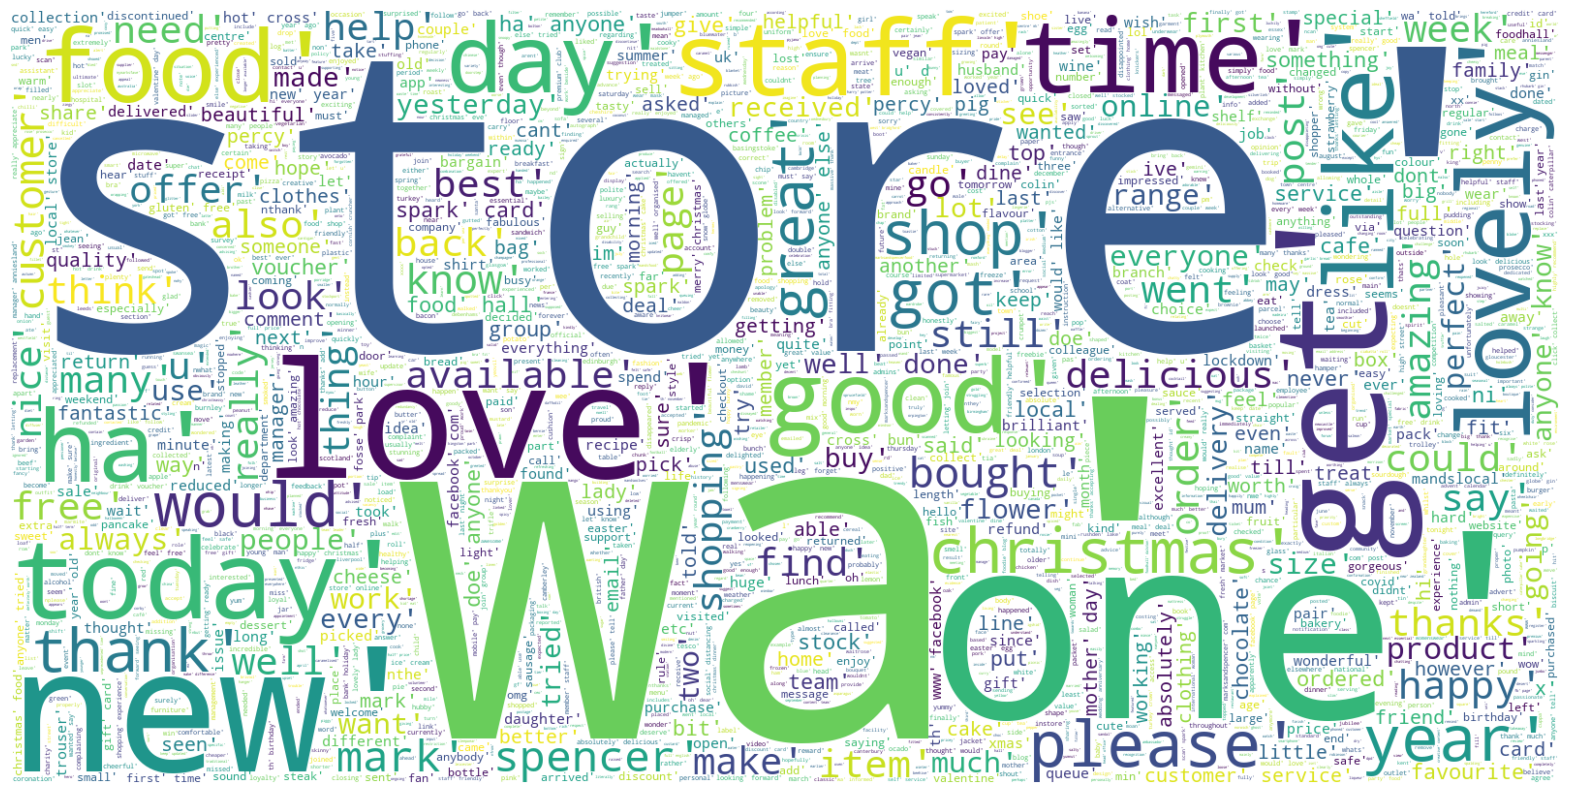

In [37]:
# Draw a positive word cloud diagram
positive_text = ms_df_normal[ms_df_normal['sentiment'] == 'positive']['content_article']
wc = WordCloud(background_color='white', max_words=2000, width=1600, height=800).generate(" ".join(positive_text))

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anacon

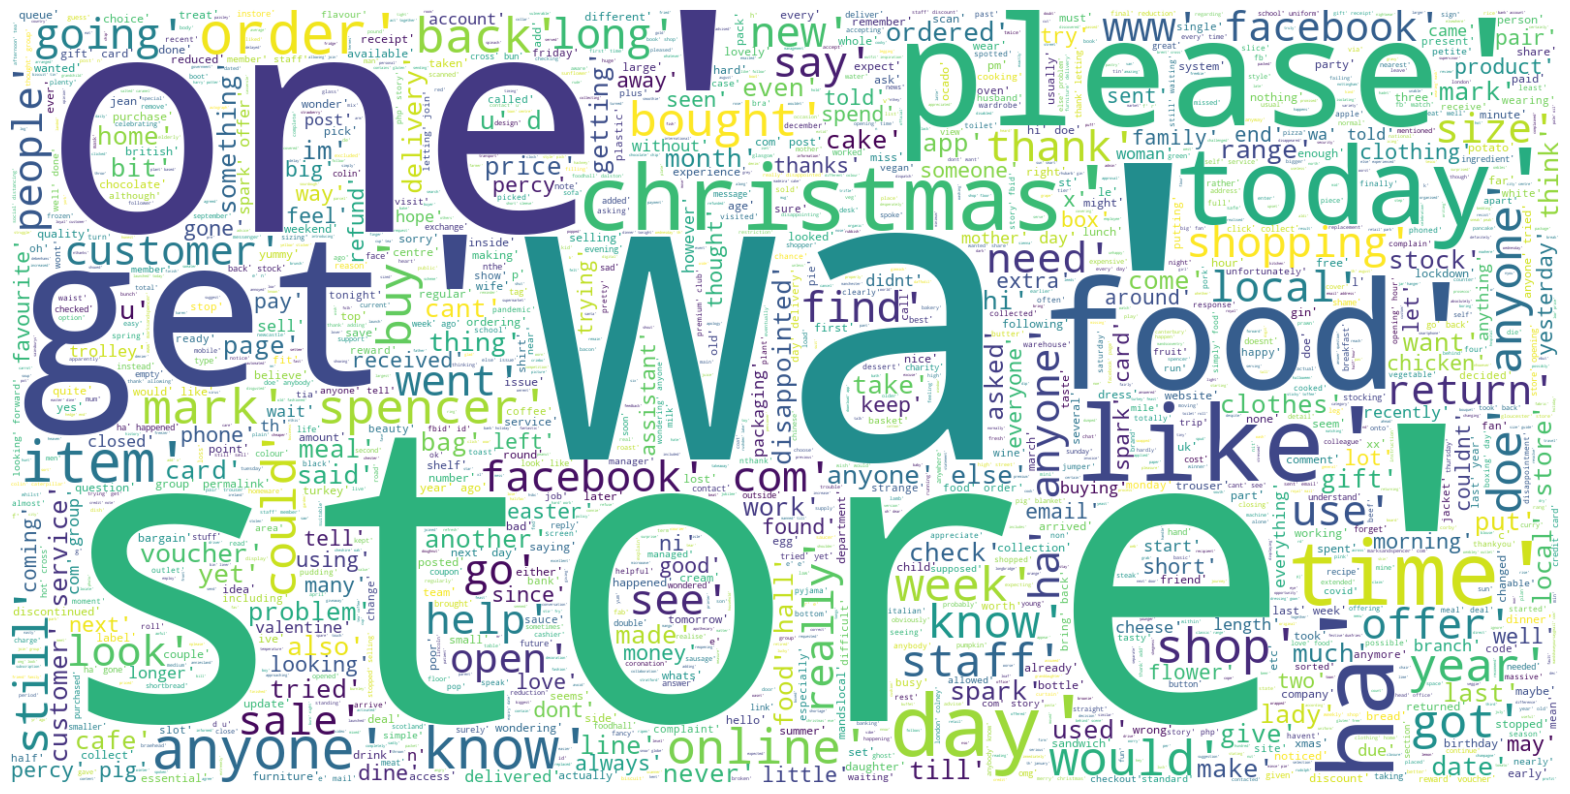

In [38]:
# Draw a neutral word cloud diagram
positive_text = ms_df_normal[ms_df_normal['sentiment'] == 'neutral']['content_article']
wc = WordCloud(background_color='white', max_words=2000, width=1600, height=800).generate(" ".join(positive_text))

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anaconda3\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\ACER\anacon

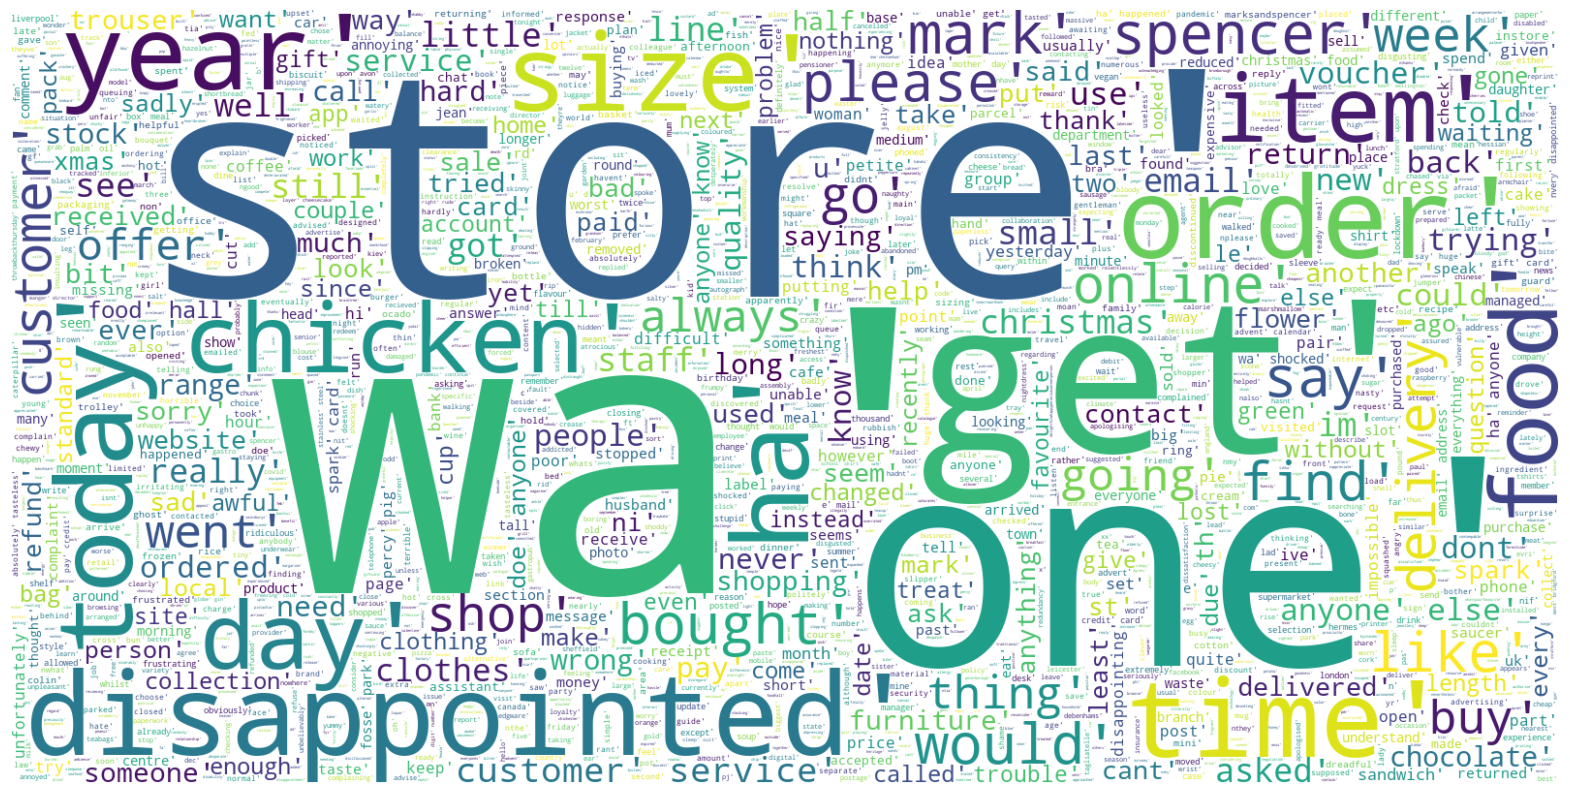

In [39]:
# Draw a negative word cloud diagram
positive_text = ms_df_normal[ms_df_normal['sentiment'] == 'negative']['content_article']
wc = WordCloud(background_color='white', max_words=2000, width=1600, height=800).generate(" ".join(positive_text))

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [64]:
# Generate sentiment scores for content
def calculate_sentiment_score(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

ms_df_normal['sentiment_score'] = ms_df_normal['content_article'].apply(calculate_sentiment_score)

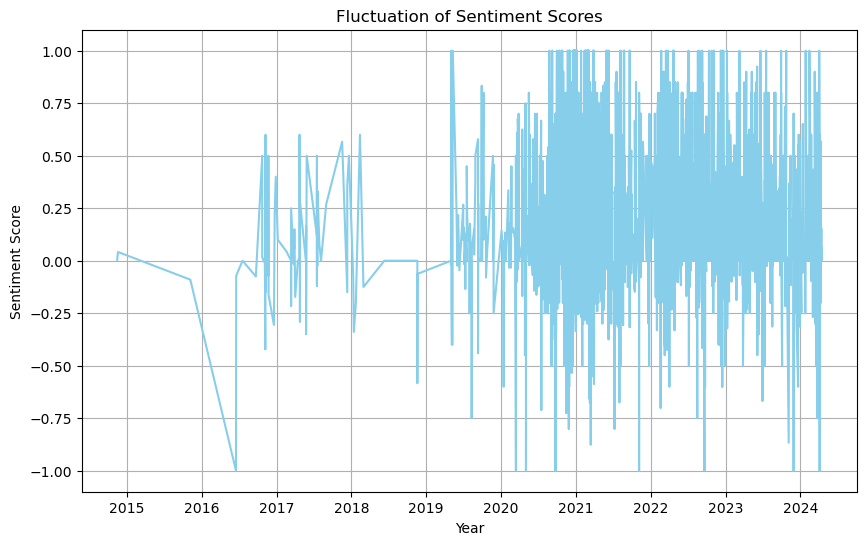

In [77]:
# Plot fluctuations in sentiment scores
# ms_df_normal.set_index('timestamp', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(ms_df_normal.index, ms_df_normal['sentiment_score'], color='skyblue', linestyle='-')
plt.title('Fluctuation of Sentiment Scores')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()

LDA Analysis

In [41]:
# Create a dictionary and corpus
dictionary = corpora.Dictionary(ms_df_normal['content'])
corpus = [dictionary.doc2bow(text) for text in ms_df_normal['content']]

In [42]:
# Apply LDA
num_topics = 5
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.022*"food" + 0.022*"store" + 0.014*"wa" + 0.011*"staff" + 0.009*"love" + 0.009*"mark" + 0.008*"lot" + 0.007*"palm" + 0.007*"spencer" + 0.007*"oil"
Topic: 1 
Words: 0.023*"’" + 0.015*"new" + 0.012*"store" + 0.012*"one" + 0.010*"u" + 0.008*"look" + 0.007*"like" + 0.007*"sure" + 0.007*"tried" + 0.007*"good"
Topic: 2 
Words: 0.018*"wa" + 0.012*"’" + 0.011*"year" + 0.011*"customer" + 0.010*"store" + 0.009*"size" + 0.009*"mark" + 0.009*"order" + 0.008*"like" + 0.008*"know"
Topic: 3 
Words: 0.019*"£" + 0.013*"com" + 0.013*"facebook" + 0.010*"story" + 0.010*"wa" + 0.008*"store" + 0.007*"’" + 0.007*"www" + 0.007*"got" + 0.006*"think"
Topic: 4 
Words: 0.014*"wa" + 0.013*"card" + 0.013*"’" + 0.011*"offer" + 0.011*"mark" + 0.011*"get" + 0.010*"time" + 0.009*"spark" + 0.008*"spencer" + 0.007*"£"


In [83]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.118121 -0.162397       1        1  37.007443
1     -0.026379  0.225487       2        1  18.064828
4     -0.115469 -0.231035       3        1  16.321898
0     -0.227589  0.051250       4        1  14.855272
3      0.251316  0.116695       5        1  13.750559, topic_info=       Term        Freq       Total Category  logprob  loglift
102    food  462.000000  462.000000  Default  30.0000  30.0000
47        £  357.000000  357.000000  Default  29.0000  29.0000
69     card  140.000000  140.000000  Default  28.0000  28.0000
481     com  119.000000  119.000000  Default  27.0000  27.0000
36    offer  125.000000  125.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
73        ’   67.916203  827.625845   Topic5  -4.9109  -0.5162
60      new   44.615111  275.001443   Topic5  -5.3311   0.1654
102    food   46.517039  462.291507   Topic5  -5.2894  -0.3123
132  please   42.408672  211.919928   Topic5  -5.3818   0.3752
191  really   37.165018  214.107789   Topic5  -5.5138   0.2330

[347 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
389       1  0.994286   account
634       3  0.987388  actually
2074      4  0.957517    adding
4600      4  0.949807     admin
5951      2  0.983600    admins
...     ...       ...       ...
73        4  0.064039         ’
73        5  0.082163         ’
2505      2  0.984920        ❤️
1083      2  0.922614         😍
1083      5  0.069196         😍

[550 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

Predictive analysis

In [44]:
# Add a column to present interaction total numbers, which equal to reaction_no and reaction_no
ms_df_normal['interaction'] = ms_df_normal['reaction_no'] + ms_df_normal['reaction_no']

ms_df_normal.describe()

timestamp  reaction_no   comment_no         year  \
count                           4125  4125.000000  4125.000000  4125.000000   
mean   2021-08-17 10:00:05.236363520    44.380606    12.770424  2021.117091   
min              2014-11-15 00:00:00     0.000000     0.000000  2014.000000   
25%              2020-12-08 00:00:00     6.000000     1.000000  2020.000000   
50%              2021-03-25 00:00:00    16.000000     5.000000  2021.000000   
75%              2022-06-16 00:00:00    45.000000    15.000000  2022.000000   
max              2024-04-14 00:00:00  1625.000000  2922.000000  2024.000000   
std                              NaN    85.932544    49.721000     1.274655   

             month         date  content_count  sentiment_score  interaction  
count  4125.000000  4125.000000    4125.000000      4125.000000  4125.000000  
mean      6.641455    15.893576      16.255758         0.172507    88.761212  
min       1.000000     1.000000       0.000000        -1.000000     0.000000  
25%       3.000000     8.000000       5.000000         0.000000    12.000000  
50%       6.000000    16.000000      11.000000         0.100000    32.000000  
75%      11.000000    23.000000      25.000000         0.347619    90.000000  
max      12.000000    31.000000      60.000000         1.000000  3250.000000  
std       3.799239     8.805891      13.632928         0.284050   171.865088

In [45]:
# Divide interaction in to three groups (0:low, 1:middle, 2:high)
def set_reaction_level(x):
    if x < 32:
        return 0
    elif 1 <90:
        return 1
    else:
        return 2

ms_df_normal['interaction_level'] = ms_df_normal['interaction'].apply(set_reaction_level)

In [46]:
# Prepare training and testing dataset
X = ms_df_normal[['content_count','sentiment_score','year','month']]
y = ms_df_normal['interaction_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

print("Train shape:     ", X_train.shape)
print("Test shape:      ", X_test.shape)

Train shape:      (2887, 4)
Test shape:       (1238, 4)


Decision Tree

In [47]:
dtc = DecisionTreeClassifier(max_depth=10, min_samples_split=2)
dtc.fit(X_train, y_train)
y_pred_dec = dtc.predict(X_test)
print('Accuracy of Decision Tree Model: {:.10f}'.format(dtc.score(X_test, y_test)))

Accuracy of Decision Tree Model: 0.5823909532


C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future v

In [48]:
acc_lr_dec = accuracy_score(y_test,y_pred_dec)
f1_lr_dec = f1_score(y_test,y_pred_dec)
prec_lr_dec = precision_score(y_test,y_pred_dec)
rec_lr_dec = recall_score(y_test,y_pred_dec)
results_lr_dec = pd.DataFrame([['Decision Tree', acc_lr_dec, f1_lr_dec, prec_lr_dec, rec_lr_dec]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
results_lr_dec

Model  Accuracy Score  F1 score  Precision    Recall
0  Decision Tree        0.582391  0.576577   0.580858  0.572358

Random Forest

In [49]:
rd = RandomForestClassifier(random_state=2)
rd.fit(X_train, y_train)
y_pred_rd = rd.predict(X_test)
print('Accuracy of Random Forest Model: {:.10f}'.format(rd.score(X_test, y_test)))

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Accuracy of Random Forest Model: 0.5888529887


C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future v

In [50]:
acc_lr_rd = accuracy_score(y_test,y_pred_rd)
f1_lr_rd = f1_score(y_test,y_pred_rd)
prec_lr_rd = precision_score(y_test,y_pred_rd)
rec_lr_rd = recall_score(y_test,y_pred_rd)
results_lr_rd = pd.DataFrame([['Random Forest', acc_lr_rd, f1_lr_rd, prec_lr_rd, rec_lr_rd]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
results_lr_rd

Model  Accuracy Score  F1 score  Precision   Recall
0  Random Forest        0.588853  0.598264   0.581288  0.61626

Gradient Boosting

In [51]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print('Accuracy of Gradient Boosting Model: {:.10f}'.format(gb.score(X_test, y_test)))

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Accuracy of Gradient Boosting Model: 0.6252019386


C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future v

In [52]:
acc_lr_gb = accuracy_score(y_test,y_pred_gb)
f1_lr_gb = f1_score(y_test,y_pred_gb)
prec_lr_gb = precision_score(y_test,y_pred_gb)
rec_lr_gb = recall_score(y_test,y_pred_gb)
results_lr_gb = pd.DataFrame([['Gradient Boosting', acc_lr_gb, f1_lr_gb, prec_lr_gb, rec_lr_gb]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
results_lr_gb

Model  Accuracy Score  F1 score  Precision    Recall
0  Gradient Boosting        0.625202  0.645802   0.608633  0.687805